# Exercise Sheet 8: Generative Adversarial Networks

In [297]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
import torch.optim as optim

from sklearn.manifold import TSNE
import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# folder path
data_path = './data'
model_path = './model'
result_path = './results'

# random seed np/torch
seed = 42
random.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# hyperparameters
img_size = 32
latent_dim = 100
batch_size = 128
num_epochs = 5
lr = 0.0001
momentum = 0.5
betas = (0.5, 0.999)


# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [298]:
# Create folder if not exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(result_path):
    os.makedirs(result_path)

#### Task 1.1: Derive optial discriminator D*

Use equation (1) as a starting point to derive the optimal discriminator D∗ in terms of data probability pdata (x) and generator probability pG (x).
Assume generator G is fixed.

The objective function V(D,G) is:


$V(D,G) = E_{x~p_{data}(x)} [log (D(x))] + E_{z~p(z)} [log (1 - D(G(z)))]$

Rewriting the objective function in terms of p_{data}(x) and p_z(x):

$
V(D,G) = \int{p_{data}(x) log(D(x)) dx + \int{p_g(x) log(1 - D(g(z))) dx}} \\
= \int{p_{data}(x) log(D(x)) dx + p_g(x) log(1-D(x)) dx}
$

#### Task 1.2: Find optimal point minimizing V

Use the obtained D∗ to find the optimal point minimizing V.
What value does D∗ have at this point and what would this value imply?


Taking the derivative of V with respect to D(x) and setting it to zero:

$\frac{dV}{dD(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{(1 - D(x))} = 0$

Solving for D*(x):

$D_G*(x) = \frac{p_{data}(x)}{(p_{data}(x) + p_g(x))}$

#### Task 2: Training a GAN

* Use Adam optimizer with a learning rate of 0.0001 and β1 = 0.5.
* Fashion-MNIST has a standard resolution of 28 × 28 so make sure to resize it to 32 × 32
* You may have to adapt the DCGAN architecture slightly to generate 32×32 images instead of 64 × 64
* Using spectral normalization on the weights of the Discriminator can help with mode collapse and make training more stable
* You should already see decent results after a couple of epochs.

In [299]:
# Download Fashion MNIST dataset

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((img_size, img_size)),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST(data_path, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

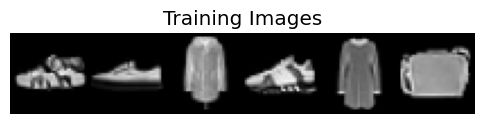

In [300]:
# Get a batch of real images
real_batch = next(iter(trainloader))
images, _ = real_batch

# Normalize the images to [0, 1] range for plotting
images = (images + 1) / 2

# Create a grid of images
grid = torchvision.utils.make_grid(images[:6], padding=2, normalize=False)

# Transpose the grid to match the expected shape for imshow
grid = np.transpose(grid.cpu().numpy(), (1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)
plt.savefig(os.path.join(result_path, 'training_images.png'))
plt.show()


In [301]:
class Generator(nn.Module):
    """ Generator generates fake images from random noise."""
    def __init__(self, input_shape, n_classes=10):
        super(Generator, self).__init__()
        self._n_classes = n_classes
        self._input_shape = input_shape
        self.embedding = nn.Embedding(self._n_classes, 100)
        # Input is a noise vector z and a class label c
        self.conv = nn.Conv2d(200, 100, (1, 1), bias=False)
        self.batch_norm = nn.BatchNorm2d(100)
        # state size. 100 x 1 x 1
        self.conv_transpose1 = nn.ConvTranspose2d(100, 512, (4, 4), (1, 1), (0, 0), bias=False)
        self.batch_norm1 = nn.BatchNorm2d(512)
        # state size. 512 x 4 x 4
        self.conv2 = nn.ConvTranspose2d(512, 256, (4, 4), (2, 2), (1, 1), bias=False)
        self.in2 = nn.InstanceNorm2d(256)
         # state size. 256 x 8 x 8
        self.conv3 = nn.ConvTranspose2d(256, 128, (4, 4), (2, 2), (1, 1), bias=False)
        self.in3 = nn.InstanceNorm2d(128)
        # state size. 128 x 16 x 16
        self.conv4 = nn.ConvTranspose2d(128, 64, (4, 4), (2, 2), (1, 1), bias=False)
        self.in4 = nn.InstanceNorm2d(64)
        # state size. 1 x 32 x 32
        self.conv5 = nn.Conv2d(64, 1, (1, 1), bias=False)

    def forward(self, z, c):
        # Concatenate the noise vector and the class label embedding
        c = self.embedding(c)
        c = c.unsqueeze(-1).unsqueeze(-1)
        c = c.expand(z.size())
        z = torch.cat([z, c], dim=1)
        # Reshape the input for 100 x 1 x 1
        x = z.view(128, 1, 200, 1)
        x = x.permute(0, 2, 1, 3)
        # Apply the convolutional layers
        x = F.relu(self.batch_norm(self.conv(x)))
        x = F.relu(self.batch_norm1(self.conv_transpose1(x)))
        x = F.relu(self.in2(self.conv2(x)))
        x = F.relu(self.in3(self.conv3(x)))
        x = F.relu(self.in4(self.conv4(x)))
        x = self.conv5(x)
        # Apply a tanh activation function
        x = nn.functional.tanh(x)
        return x

class Discriminator(nn.Module):
    """ Discriminator classifies real and fake images.
        The discriminator is a convolutional neural network that classifies images as real or fake.

        Image shape: torch.Size([128, 1, 32, 32])
        Embeddings shape: torch.Size([128, 100])
    """
    def __init__(self, input_shape, n_classes=10):
        super(Discriminator, self).__init__()
        self._n_classes = n_classes
        self._input_shape = input_shape
        self.embedding = nn.Embedding(self._n_classes, 100)
        # Input is an image and a class label c
        # Concatenated input shape: X torch.Size([128, 101, 32, 32])
        self.conv1 = spectral_norm(nn.Conv2d(101, 64, (4, 4), (2, 2), (1, 1), bias=False))
        # state size. 64 x 16 x 16
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, (4, 4), (2, 2), (1, 1), bias=False))
        self.in2 = nn.InstanceNorm2d(128)
        self.dropout = nn.Dropout(0.2)
        # state size. 128 x 8 x 8
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, (4, 4), (2, 2), (1, 1), bias=False))
        self.in3 = nn.InstanceNorm2d(256)
        # Dense output layer
        self.fc = nn.Linear(256 * 4 * 4, 1)

    # Image shape: torch.Size([128, 1, 32, 32])
    # Embeddings shape: torch.Size([128, 50, 1, 1])

    def forward(self, x, c):
        # Concatenate the image and the class label embedding
        c = self.embedding(c)
        c = c.unsqueeze(-1).unsqueeze(-1)
        c = c.expand(-1,-1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)

        # Apply the convolutional layers
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.in2(self.conv2(x)), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.in3(self.conv3(x)), 0.2)
        # Flatten the output
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc(x)
        x = F.sigmoid(x)
        return x

class DCGAN(nn.Module):
    """ DCGAN defines the architecture of the GAN model."""
    def __init__(self, latent_dim=100, img_size=32, lr=1e-4, betas=(0.5, 0.999), device=None, n_classes=10):
        super(DCGAN, self).__init__()

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self._device = device
        self._lr = lr
        self._betas = betas
        self._latent_dim = latent_dim
        self._img_size = img_size
        self._n_classes = n_classes
        self._input_shape = (1, self._img_size, self._img_size)
        self._fixed_noise = torch.randn(self._n_classes, self._latent_dim, 5, 5, device=self._device)

        # Establish convention for real and fake labels during training
        self._real_label = 1
        self._fake_label = 0

        # Initialize generator and discriminator
        self.generator = Generator(n_classes=n_classes, input_shape=self._input_shape).to(self._device)
        self.discriminator = Discriminator(n_classes=n_classes, input_shape=self._input_shape).to(self._device)

        if self._device.type == 'cuda':
            self.generator = nn.DataParallel(self.generator)
            self.discriminator = nn.DataParallel(self.discriminator)

        # Initialize weights
        self.generator.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)

        # Initialize optimizers and criterion
        self.criteria = nn.BCELoss()
        self.binary_accuracy = nn.BCEWithLogitsLoss()
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=self._lr, betas=self._betas)
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self._lr, betas=self._betas)

    def forward(self, z):
        return self.generator(z)

    def sample_random_z(self, n=1):
        sample = torch.randn(n, self._latent_dim, 1, 1, device=self._device)
        return sample

    def sample_fixed_z(self, n=5):
        # Generate fixed noise and labels
        fixed_noise = torch.randn(self._n_classes, self._latent_dim, n, n, device=self._device)
        fixed_labels = torch.tensor([i for i in range(self._n_classes) for _ in range(n*n)], device=self._device)
        return fixed_noise.view(-1, self._latent_dim, 1, 1), fixed_labels

    def sample_G(self, n=5, type='fixed'):
        if type == 'fixed':
            z, labels = self.sample_fixed_z(n)
        else:
            z = self.sample_random_z(n * self.num_classes)
            labels = torch.tensor([i for i in range(self._n_classes) for _ in range(n*n)], device=self._device)

        # Generate images for each class
        images = []
        for i in range(self._n_classes):
            labels_i = labels == i
            images.append(self.G(z[labels_i], labels[labels_i]).view(n, n, -1))

        # Concatenate images for all classes
        images = torch.cat(images, dim=0)
        return images

    def adversarial_loss(self, y_hat, y):
        # Adversarial loss
        return self.criteria(y_hat, y)

    def generator_loss(self, fake):
        # Generator loss
        return self.adversarial_loss(self.discriminator(fake), torch.ones(fake.size(0), 1, device=self._device))

    def discriminator_loss(self, real, fake):
        # Discriminator loss
        real_pred = self.discriminator(real)
        real_loss = self.adversarial_loss(real_pred, torch.ones(real.size(0), 1, device=self._device))
        fake_pred = self.discriminator(fake.detach())
        fake_loss = self.adversarial_loss(fake_pred, torch.zeros(fake.size(0), 1, device=self._device))
        return real_loss + fake_loss

    def train_step(self, real_images, real_labels):
        
        # if not on device move to device
        if real_images.device != self._device:
            real_images = real_images.to(self._device)
        
        if real_labels.device != self._device:
            real_labels = real_labels.to(self._device)

        # ============================================================= #
        # ================== Train the discriminator ================== #
        # ============================================================= #
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        # Train the discriminator with real images
        self.discriminator.train()
        self.discriminator.zero_grad()
    
        # Create pseudo labels for real images
        labels = torch.full((real_images.size(0), ), self._real_label, dtype=torch.float32, device=self._device)
        
        # Forward pass
        real_pred = self.discriminator(real_images, real_labels).view(-1)
        real_loss = self.adversarial_loss(real_pred, labels)
        real_acc = self.binary_accuracy(real_pred, labels)
        real_loss.backward()

        # Train the discriminator with fake images
        z = self.sample_random_z(real_images.size(0))
        fake_labels = torch.randint(0, self._n_classes, (real_images.size(0),), device=self._device)
        fake_images = self.generator(z, fake_labels)
        labels.fill_(self._fake_label)

        # Forward pass
        fake_pred = self.discriminator(fake_images.detach(), fake_labels).view(-1)
        fake_loss = self.adversarial_loss(fake_pred, labels)
        fake_acc = self.binary_accuracy(fake_pred, labels)
        fake_loss.backward()

        # Total Discriminator loss
        d_loss = real_loss + fake_loss

        # Update Discriminator weights
        self.optimizer_D.step()

        # Compute overall avg. accuracy
        acc = (real_acc + fake_acc) / 2

        # ============================================================= #
        # ===================== Train the generator =================== #
        # ============================================================= #
        # (2) Update G network: maximize log(D(G(z)))

        # Train the generator with random noise z and real labels
        self.generator.train()
        self.generator.zero_grad()

        # Generate fake labels
        labels.fill_(self._real_label) # fake labels are real for generator cost
        # Forward pass
        output = self.discriminator(fake_images, fake_labels).view(-1)

        # Generator loss
        g_loss = self.adversarial_loss(output, labels)
        g_loss.backward()

        # Update Generator weights
        self.optimizer_G.step()

        return d_loss, g_loss, real_acc, fake_acc, acc

    # custom weights initialization called on ``netG`` and ``netD``
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

    def plot(self, images, n_rows=5, n_cols=10, save=False, path='results/result.png'):
        """ Plot a list of images in a grid format."""
        n_cols = len(images) // n_rows if n_cols is None else n_cols
        with torch.no_grad():
            # Reshape the images to (n, 1, 32, 32)
            images = torch.stack(images).cpu()
            images = images.numpy()
            # Plot all the images in the list
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
            fig.suptitle(f'Generated Images')
            for i, ax in enumerate(axes.flat):
                ax.imshow(images[i, 0], cmap='gray')  # Reshape to (32, 32)
                ax.axis('off')
                ax.title.set_text(f'Image {i+1}')
            if save:
                plt.savefig(path)
            plt.show()

In [302]:
# Initialize DCGAN
dcgan = DCGAN(latent_dim=latent_dim, img_size=img_size, lr=lr, betas=betas, device=device)

d_fake_img_acc = []
d_real_img_acc = []
d_training_losses = []
g_training_losses = []

fake_img_list = []

# Train DCGAN
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        real_images = data[0].to(device)
        real_labels = data[1].to(device)

        # Train the DCGAN
        d_loss, g_loss, real_acc, fake_acc, acc = dcgan.train_step(real_images, real_labels)

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, num_epochs, i+1, len(trainloader), d_loss.item(), g_loss.item()))

        # Save Losses for plotting later
        d_training_losses.append(d_loss.item())
        g_training_losses.append(g_loss.item())

        # Save Discriminator Accuracy for plotting later
        d_fake_img_acc.append(fake_acc.item())
        d_real_img_acc.append(real_acc.item())


    # Generate 10 x 5 images for each epoch
    with torch.no_grad():
        images = dcgan.sample_G(n=5, type='fixed')
        fake_img_list.append(images)

# Plot some images generated by the DCGAN
dcgan.plot(fake_img_list, n_rows=10, save=True, path=os.path.join(result_path, 'fake_images.png'))

# Save the model under model_path
dcgan.save(model_path + '/dcgan.pth')


Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Size([128])
Embedded Shape of c: torch.Size([128, 100, 1, 1])
Cat Shape of z: torch.Size([128, 200, 1, 1])
Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Size([128])
Embedded Shape of c: torch.Size([128, 100, 1, 1])
Cat Shape of z: torch.Size([128, 200, 1, 1])
Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Size([128])
Embedded Shape of c: torch.Size([128, 100, 1, 1])
Cat Shape of z: torch.Size([128, 200, 1, 1])
Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Size([128])
Embedded Shape of c: torch.Size([128, 100, 1, 1])
Cat Shape of z: torch.Size([128, 200, 1, 1])
Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Size([128])
Embedded Shape of c: torch.Size([128, 100, 1, 1])
Cat Shape of z: torch.Size([128, 200, 1, 1])
Generator forward
Shape of z: torch.Size([128, 100, 1, 1])
Shape of c: torch.Siz

KeyboardInterrupt: 

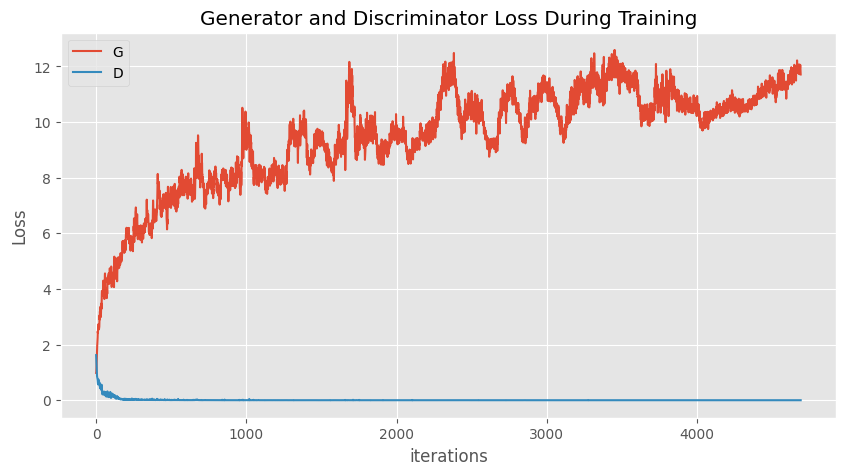

In [ ]:
# Plot evolution of the training losses for the generator and discriminator
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_training_losses, label="G")
plt.plot(d_training_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(result_path + '/loss.png')
plt.show()

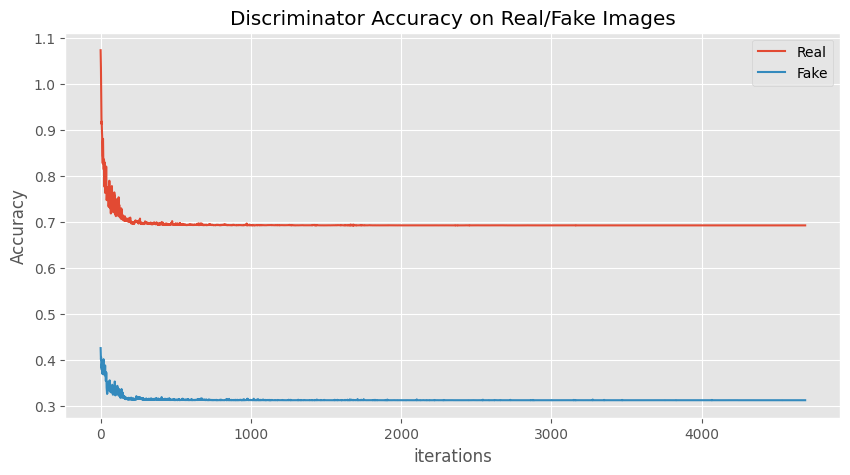

In [ ]:
# Plot classification accuracy of the discriminator on real/fake samples
plt.figure(figsize=(10, 5))
plt.title("Discriminator Accuracy on Real/Fake Images")
plt.plot(d_fake_img_acc, label="Real")
plt.plot(d_real_img_acc, label="Fake")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig(result_path + '/accuracy.png')
plt.show()

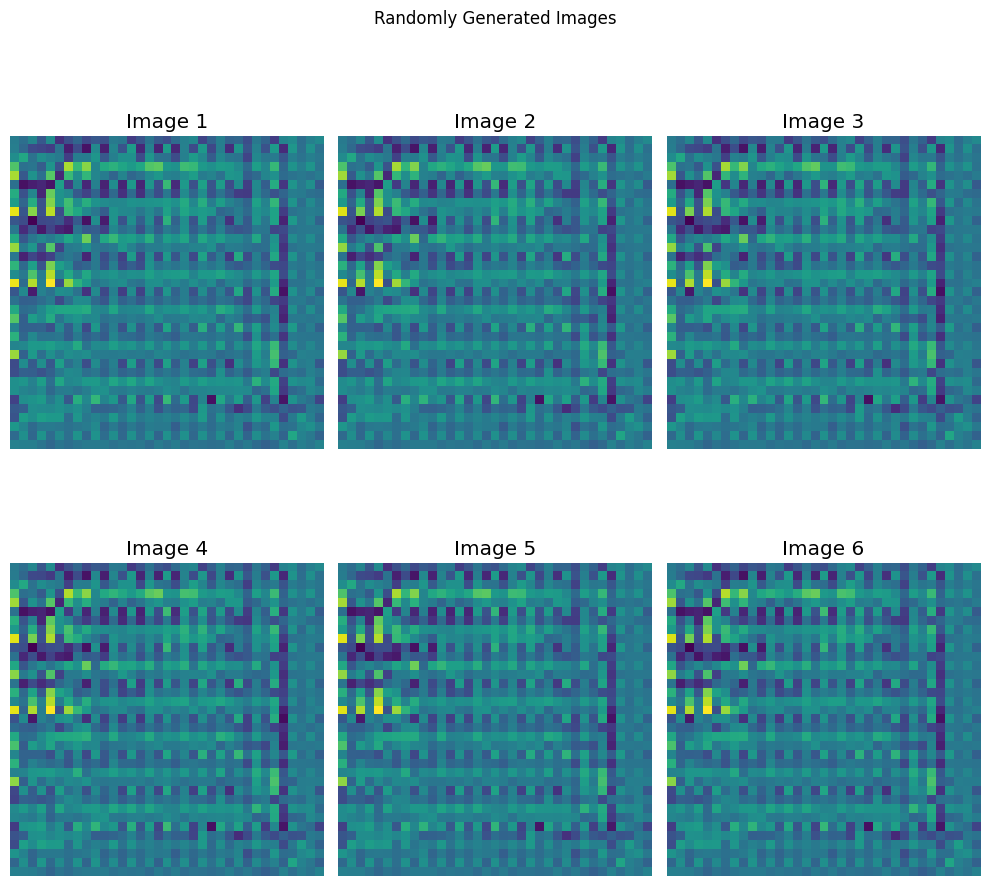

In [ ]:
# Plot 6 randomly synthesized images from the generator in a grid
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
fig.suptitle("Randomly Generated Images")
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(fake_img_list[-1][i], (1, 2, 0)))
    ax.axis('off')
    ax.title.set_text(f"Image {i+1}")
plt.tight_layout()
plt.savefig(result_path + '/generated_images.png')
plt.show()


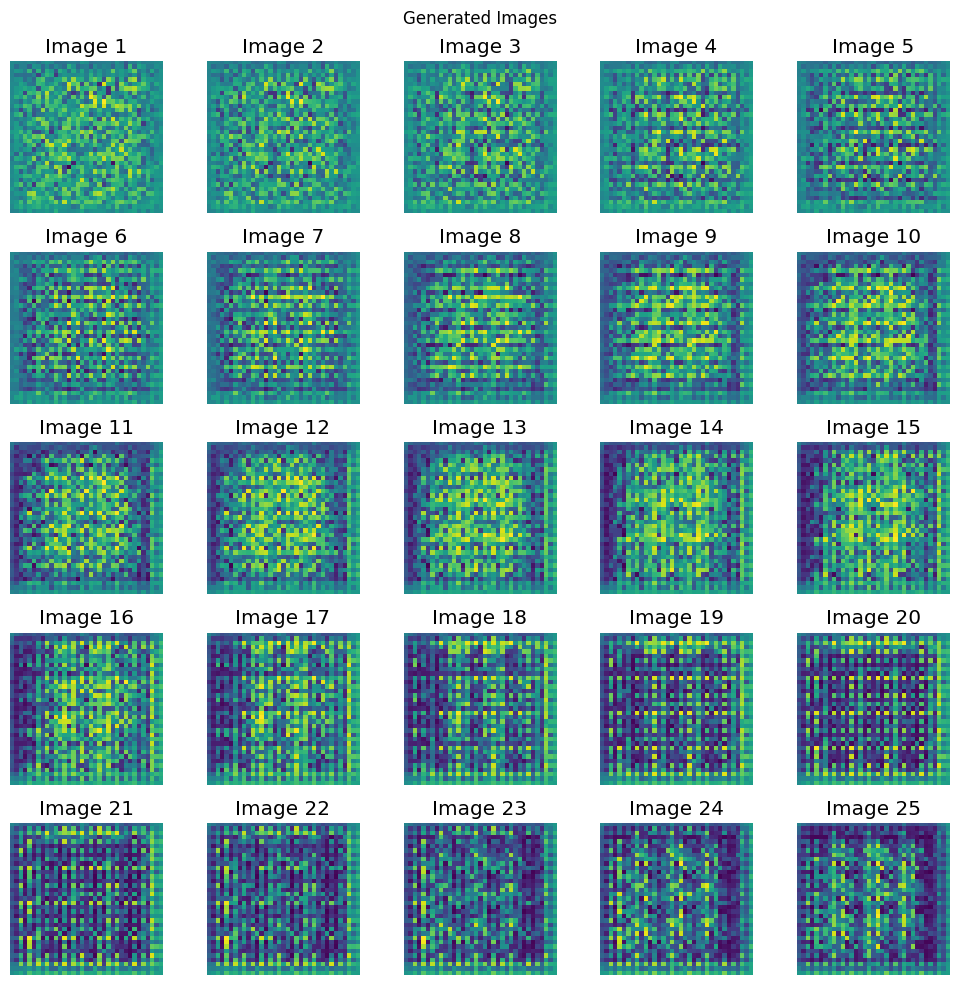

In [ ]:
# Plot collected images for evolution of the generator during training
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("Generated Images")
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(fake_img_list[i][0], (1, 2, 0)))
    ax.axis('off')
    ax.title.set_text(f"Image {i+1}")
plt.tight_layout()
plt.savefig(result_path + '/generated_images_evolution.png')
plt.show()

In [ ]:
from tqdm import tqdm

# Load the pretrained model and remove the last layer
resnet18 = torchvision.models.resnet18(pretrained=True)
# Update the first layer to accept grayscale images
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1]).to(device)
resnet18.eval()

# Extract features from the last convolutional layer of the model
def get_features(model, dataloader):
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_ in tqdm(dataloader):
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten the output
            features.append(output.detach().cpu())
            labels.append(labels_)
    return torch.cat(features), torch.cat(labels)

# Extract features from the train and test splits
train_features, train_labels = get_features(resnet18, trainloader)
test_features, test_labels = get_features(resnet18, testloader)


100%|██████████| 79/79 [00:04<00:00, 18.92it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


In [ ]:
# Select 5 classes for the task
classes = [0, 1, 2, 3, 4]

# Generate images using the generator and extract features
n = 500
batch_size = 8
fake_features = []
fake_labels = []

for cls in classes:
    # Sample noise vectors conditioned on the class label
    z = dcgan.sample_random_z(n, cls)
    fake_images = dcgan.generator(z)
    with torch.no_grad():
        batch_features = resnet18(fake_images)
        fake_features.append(batch_features.cpu())
        fake_labels.extend([cls] * n)

fake_features = torch.cat(fake_features)
fake_labels = torch.tensor(fake_labels)

In [ ]:
# Concatenate the features and labels
features = torch.cat([train_features, test_features, fake_features])
labels = torch.cat([train_labels, test_labels, fake_labels])

In [ ]:
# Perform t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(features.reshape(features.shape[0], -1))

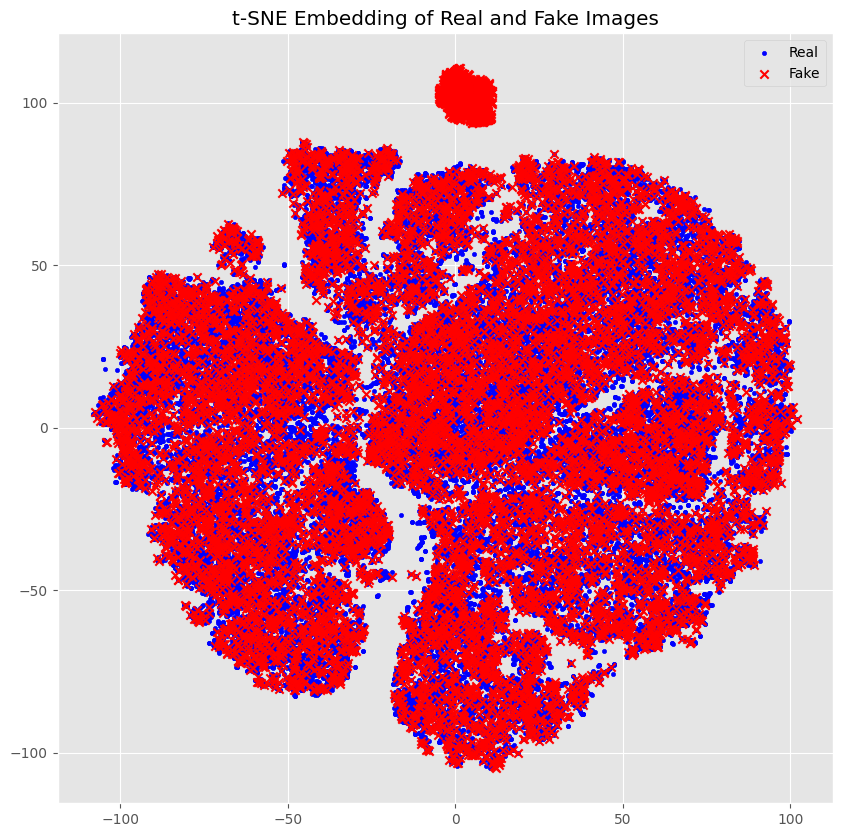

In [ ]:
# Plot the t-SNE embedding
plt.figure(figsize=(10, 10))
plt.title("t-SNE Embedding of Real and Fake Images")

# Plot real images as blue dots
plt.scatter(X_embedded[:train_features.shape[0], 0], X_embedded[:train_features.shape[0], 1], c='blue', marker='.', label='Real')
# Plot test images as green dots
plt.scatter(X_embedded[train_features.shape[0]:train_features.shape[0]+test_features.shape[0], 0], X_embedded[train_features.shape[0]:train_features.shape[0]+test_features.shape[0], 1], c='green', marker='.', label='Test')
# Plot fake images as red x's
plt.scatter(X_embedded[-n*len(classes):, 0], X_embedded[-n*len(classes):, 1], c='red', marker='x', label='Fake')

for i, cls in enumerate(classes):
    # Plot fake images for each class as different colored x's
    plt.scatter(X_embedded[-n*len(classes):, 0][fake_labels==cls], X_embedded[-n*len(classes):, 1][fake_labels==cls], c=plt.cm.tab20(i), marker='x')

plt.legend()
plt.savefig(result_path + '/tsne.png')
plt.show()

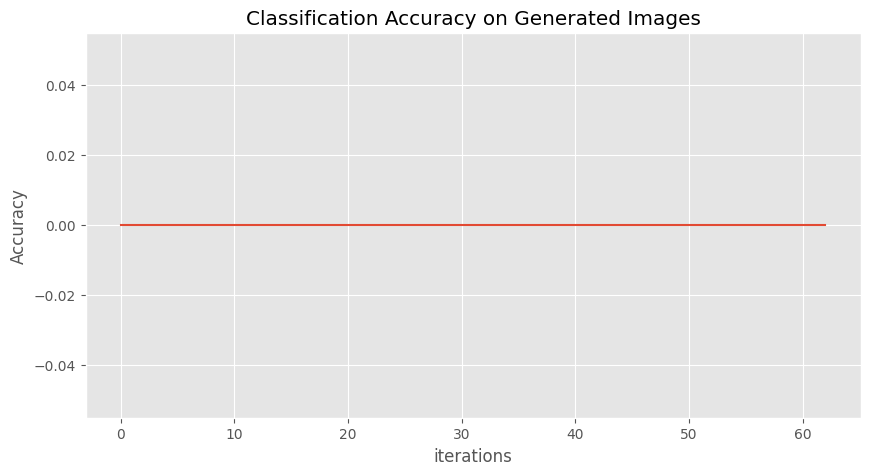

In [ ]:
# Plot the classification accuracy on generated data using the previous ResNet18 classifier
acc = []
n = 1000

# Concatenate the tensors in fake_img_list
fake_imgs = torch.cat(fake_img_list)

# Evaluate the classifier on the generated images
for i in range(0, n, batch_size):
    with torch.no_grad():
        output = resnet18(fake_imgs[i:i+batch_size].to(device))
        output = output.view(output.size(0), -1)
        pred = torch.argmax(output, 1)
        acc.append((pred == 10).sum().item() / batch_size)

# Plot the classification accuracy
plt.figure(figsize=(10, 5))
plt.title("Classification Accuracy on Generated Images")
plt.plot(acc)
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig(result_path + '/classification_accuracy.png')
plt.show()
